# ЭТАП 3: Machine Learning Experiments

**Цель**: Экспериментирование с различными алгоритмами машинного обучения для предсказания популярности треков, сравнение их производительности и выбор лучшей модели.

---


# Импорт библиотек


In [1]:
# Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Линейные модели
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Древовидные модели
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# Градиентный бустинг
try:
    import xgboost as xgb
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠ XGBoost не установлен")

try:
    import lightgbm as lgb
    from lightgbm import LGBMRegressor
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠ LightGBM не установлен")

try:
    from catboost import CatBoostRegressor
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("⚠ CatBoost не установлен")

# Нейронные сети
from sklearn.neural_network import MLPRegressor

print("Библиотеки импортированы успешно!")
print(f"XGBoost: {'✓' if XGBOOST_AVAILABLE else '✗'}")
print(f"LightGBM: {'✓' if LIGHTGBM_AVAILABLE else '✗'}")
print(f"CatBoost: {'✓' if CATBOOST_AVAILABLE else '✗'}")


Библиотеки импортированы успешно!
XGBoost: ✓
LightGBM: ✓
CatBoost: ✓


# Загрузка данных и создание признаков


In [2]:
# Загрузка датасета
import os

# Определяем путь к датасету
dataset_path = os.path.join('..', 'src', 'dataset', 'dataset.csv')
if not os.path.exists(dataset_path):
    # Альтернативный путь для Google Colab
    dataset_path = '/content/dataset.csv' if os.path.exists('/content/dataset.csv') else 'dataset.csv'

df = pd.read_csv(dataset_path, index_col=0)

print(f"Загружено записей: {len(df)}")
print(f"Количество колонок: {len(df.columns)}")
print(f"Размер в памяти: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Загружено записей: 114000
Количество колонок: 20
Размер в памяти: 49.66 MB


In [3]:
# Создание признаков (повторяем логику из ноутбука 04)
from sklearn.preprocessing import PolynomialFeatures

print("="*70)
print("СОЗДАНИЕ ПРИЗНАКОВ")
print("="*70)

df_features = df.copy()

# Обязательные признаки
df_features['duration_min'] = df_features['duration_ms'] / 60000
df_features['energy_dance_ratio'] = df_features['energy'] / (df_features['danceability'] + 1e-6)
df_features['acoustic_energy_balance'] = df_features['acousticness'] * (1 - df_features['energy'])
df_features['tempo_energy_product'] = df_features['tempo'] * df_features['energy']
df_features['valence_energy_interaction'] = df_features['valence'] * df_features['energy']

# Логарифмические трансформации
df_features['log_duration_ms'] = np.log1p(df_features['duration_ms'])
df_features['log_instrumentalness'] = np.log1p(df_features['instrumentalness'] * 1e6) / np.log(1e6 + 1)
df_features['log_speechiness'] = np.log1p(df_features['speechiness'] * 1e6) / np.log(1e6 + 1)
df_features['log_loudness'] = np.log1p(df_features['loudness'] + 60)

# Бинаризация
df_features['is_high_energy'] = (df_features['energy'] > 0.7).astype(int)
df_features['is_major_mode'] = df_features['mode'].astype(int)
df_features['is_high_danceability'] = (df_features['danceability'] > 0.7).astype(int)
df_features['is_high_valence'] = (df_features['valence'] > 0.7).astype(int)
if 'explicit' in df_features.columns:
    df_features['is_explicit'] = df_features['explicit'].astype(int)

# Полиномиальные взаимодействия
key_features_for_poly = ['danceability', 'valence', 'energy', 'tempo']
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly_features = poly.fit_transform(df_features[key_features_for_poly])
poly_feature_names = poly.get_feature_names_out(key_features_for_poly)

for feature_name in poly_feature_names:
    if ' ' in feature_name:
        clean_name = feature_name.replace(' ', '_')
        if clean_name not in df_features.columns:
            idx = list(poly_feature_names).index(feature_name)
            df_features[clean_name] = poly_features[:, idx]

print(f"✓ Создано признаков: {len(df_features.columns) - len(df.columns)}")
print(f"✓ Итого признаков: {len(df_features.columns)}")


СОЗДАНИЕ ПРИЗНАКОВ
✓ Создано признаков: 20
✓ Итого признаков: 40


In [4]:
# Подготовка данных для обучения
# Выбираем только числовые признаки
numeric_features = df_features.select_dtypes(include=[np.number]).columns.tolist()

# Исключаем таргет и идентификаторы
if 'popularity' in numeric_features:
    numeric_features.remove('popularity')
if 'track_id' in numeric_features:
    numeric_features.remove('track_id')

# Исключаем категориальные признаки
categorical_to_exclude = ['key', 'mode', 'time_signature']
numeric_features = [f for f in numeric_features if f not in categorical_to_exclude]

X = df_features[numeric_features].copy()
y = df_features['popularity'].copy()

# Проверка на пропуски
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())

# Разделение на train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Стандартизация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Сохраняем как DataFrame для удобства
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("="*70)
print("ПОДГОТОВКА ДАННЫХ")
print("="*70)
print(f"Количество признаков: {len(numeric_features)}")
print(f"Train размер: {X_train.shape[0]:,} записей")
print(f"Test размер: {X_test.shape[0]:,} записей")
print(f"Стандартизация применена: ✓")


ПОДГОТОВКА ДАННЫХ
Количество признаков: 30
Train размер: 91,200 записей
Test размер: 22,800 записей
Стандартизация применена: ✓


In [5]:
# Функция для расчета MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    """Расчет MAPE"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Избегаем деления на ноль
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Функция для оценки модели
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, use_scaled=True):
    """Оценка модели с расчетом метрик и времени"""
    results = {'model_name': model_name}
    
    # Обучение
    start_time = time.time()
    if use_scaled:
        model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train)
    train_time = time.time() - start_time
    results['train_time'] = train_time
    
    # Предсказания
    start_time = time.time()
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    results['predict_time'] = predict_time
    
    # Метрики для train
    results['train_mae'] = mean_absolute_error(y_train, y_train_pred)
    results['train_rmse'] = np.sqrt(mean_squared_error(y_train, y_train_pred))
    results['train_r2'] = r2_score(y_train, y_train_pred)
    results['train_mape'] = mean_absolute_percentage_error(y_train, y_train_pred)
    
    # Метрики для test
    results['test_mae'] = mean_absolute_error(y_test, y_test_pred)
    results['test_rmse'] = np.sqrt(mean_squared_error(y_test, y_test_pred))
    results['test_r2'] = r2_score(y_test, y_test_pred)
    results['test_mape'] = mean_absolute_percentage_error(y_test, y_test_pred)
    
    return results, y_test_pred

print("Функции для оценки моделей созданы ✓")


Функции для оценки моделей созданы ✓


---
# ЗАДАЧА 1: Линейные модели

## Цель
Оценить эффективность линейных моделей с различными типами регуляризации.


In [6]:
# Список для хранения результатов
all_results = []

print("="*70)
print("ОБУЧЕНИЕ ЛИНЕЙНЫХ МОДЕЛЕЙ")
print("="*70)

# 1. Linear Regression
print("\n1. Linear Regression...")
lr_model = LinearRegression()
results, _ = evaluate_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test, 
                           "Linear Regression", use_scaled=True)
all_results.append(results)
print(f"   Test R²: {results['test_r2']:.4f}, Test MAE: {results['test_mae']:.2f}")

# 2. Ridge Regression
print("\n2. Ridge Regression...")
ridge_model = Ridge(alpha=1.0, random_state=42)
results, _ = evaluate_model(ridge_model, X_train_scaled, X_test_scaled, y_train, y_test,
                           "Ridge Regression", use_scaled=True)
all_results.append(results)
print(f"   Test R²: {results['test_r2']:.4f}, Test MAE: {results['test_mae']:.2f}")

# 3. Lasso Regression
print("\n3. Lasso Regression...")
lasso_model = Lasso(alpha=0.1, random_state=42, max_iter=2000)
results, _ = evaluate_model(lasso_model, X_train_scaled, X_test_scaled, y_train, y_test,
                           "Lasso Regression", use_scaled=True)
all_results.append(results)
print(f"   Test R²: {results['test_r2']:.4f}, Test MAE: {results['test_mae']:.2f}")

print("\n" + "="*70)
print("ЛИНЕЙНЫЕ МОДЕЛИ ЗАВЕРШЕНЫ")
print("="*70)


ОБУЧЕНИЕ ЛИНЕЙНЫХ МОДЕЛЕЙ

1. Linear Regression...
   Test R²: 0.0412, Test MAE: 18.01

2. Ridge Regression...
   Test R²: 0.0412, Test MAE: 18.01

3. Lasso Regression...
   Test R²: 0.0329, Test MAE: 18.19

ЛИНЕЙНЫЕ МОДЕЛИ ЗАВЕРШЕНЫ


---
# ЗАДАЧА 2: Древовидные модели

## Цель
Оценить способность древовидных моделей к захвату нелинейных зависимостей.


In [7]:
print("="*70)
print("ОБУЧЕНИЕ ДРЕВОВИДНЫХ МОДЕЛЕЙ")
print("="*70)

# 1. Decision Tree Regressor
print("\n1. Decision Tree Regressor...")
dt_model = DecisionTreeRegressor(max_depth=20, min_samples_split=10, 
                                  min_samples_leaf=5, random_state=42)
results, _ = evaluate_model(dt_model, X_train, X_test, y_train, y_test,
                           "Decision Tree", use_scaled=False)
all_results.append(results)
print(f"   Test R²: {results['test_r2']:.4f}, Test MAE: {results['test_mae']:.2f}")

# 2. Random Forest Regressor
print("\n2. Random Forest Regressor...")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, 
                                  min_samples_split=10, min_samples_leaf=5,
                                  random_state=42, n_jobs=-1, verbose=0)
results, _ = evaluate_model(rf_model, X_train, X_test, y_train, y_test,
                           "Random Forest", use_scaled=False)
all_results.append(results)
print(f"   Test R²: {results['test_r2']:.4f}, Test MAE: {results['test_mae']:.2f}")

# 3. Extra Trees Regressor
print("\n3. Extra Trees Regressor...")
et_model = ExtraTreesRegressor(n_estimators=100, max_depth=20,
                                min_samples_split=10, min_samples_leaf=5,
                                random_state=42, n_jobs=-1, verbose=0)
results, _ = evaluate_model(et_model, X_train, X_test, y_train, y_test,
                           "Extra Trees", use_scaled=False)
all_results.append(results)
print(f"   Test R²: {results['test_r2']:.4f}, Test MAE: {results['test_mae']:.2f}")

print("\n" + "="*70)
print("ДРЕВОВИДНЫЕ МОДЕЛИ ЗАВЕРШЕНЫ")
print("="*70)


ОБУЧЕНИЕ ДРЕВОВИДНЫХ МОДЕЛЕЙ

1. Decision Tree Regressor...
   Test R²: 0.2050, Test MAE: 14.77

2. Random Forest Regressor...
   Test R²: 0.4231, Test MAE: 13.19

3. Extra Trees Regressor...
   Test R²: 0.4157, Test MAE: 13.35

ДРЕВОВИДНЫЕ МОДЕЛИ ЗАВЕРШЕНЫ


---
# ЗАДАЧА 3: Градиентный бустинг

## Цель
Оценить производительность современных ансамблевых методов градиентного бустинга.


In [8]:
print("="*70)
print("ОБУЧЕНИЕ МОДЕЛЕЙ ГРАДИЕНТНОГО БУСТИНГА")
print("="*70)

# 1. XGBoost Regressor
if XGBOOST_AVAILABLE:
    print("\n1. XGBoost Regressor...")
    xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1,
                             min_child_weight=3, subsample=0.8, colsample_bytree=0.8,
                             random_state=42, n_jobs=-1, verbosity=0)
    results, _ = evaluate_model(xgb_model, X_train, X_test, y_train, y_test,
                               "XGBoost", use_scaled=False)
    all_results.append(results)
    print(f"   Test R²: {results['test_r2']:.4f}, Test MAE: {results['test_mae']:.2f}")
else:
    print("\n1. XGBoost Regressor - пропущен (не установлен)")

# 2. LightGBM Regressor
if LIGHTGBM_AVAILABLE:
    print("\n2. LightGBM Regressor...")
    lgb_model = LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1,
                              min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
                              random_state=42, n_jobs=-1, verbose=-1)
    results, _ = evaluate_model(lgb_model, X_train, X_test, y_train, y_test,
                               "LightGBM", use_scaled=False)
    all_results.append(results)
    print(f"   Test R²: {results['test_r2']:.4f}, Test MAE: {results['test_mae']:.2f}")
else:
    print("\n2. LightGBM Regressor - пропущен (не установлен)")

# 3. CatBoost Regressor
if CATBOOST_AVAILABLE:
    print("\n3. CatBoost Regressor...")
    cat_model = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1,
                                 random_seed=42, verbose=False, thread_count=-1)
    results, _ = evaluate_model(cat_model, X_train, X_test, y_train, y_test,
                               "CatBoost", use_scaled=False)
    all_results.append(results)
    print(f"   Test R²: {results['test_r2']:.4f}, Test MAE: {results['test_mae']:.2f}")
else:
    print("\n3. CatBoost Regressor - пропущен (не установлен)")

print("\n" + "="*70)
print("МОДЕЛИ ГРАДИЕНТНОГО БУСТИНГА ЗАВЕРШЕНЫ")
print("="*70)


ОБУЧЕНИЕ МОДЕЛЕЙ ГРАДИЕНТНОГО БУСТИНГА

1. XGBoost Regressor...
   Test R²: 0.1943, Test MAE: 16.17

2. LightGBM Regressor...
   Test R²: 0.1653, Test MAE: 16.49

3. CatBoost Regressor...
   Test R²: 0.1169, Test MAE: 17.08

МОДЕЛИ ГРАДИЕНТНОГО БУСТИНГА ЗАВЕРШЕНЫ


---
# ЗАДАЧА 4: Нейронные сети

## Цель
Оценить эффективность глубокого обучения для задачи регрессии.


In [9]:
print("="*70)
print("ОБУЧЕНИЕ НЕЙРОННОЙ СЕТИ")
print("="*70)

# MLPRegressor с 2 скрытыми слоями
# Архитектура: (n_features, 128, 64, 1)
# Активация: ReLU, оптимизатор: Adam
print("\nMLPRegressor (Multi-Layer Perceptron)...")
mlp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64),  # 2 скрытых слоя
    activation='relu',
    solver='adam',
    alpha=0.001,  # L2 регуляризация
    batch_size=256,
    learning_rate='adaptive',
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42,
    verbose=False
)

results, _ = evaluate_model(mlp_model, X_train_scaled, X_test_scaled, y_train, y_test,
                           "MLP Regressor", use_scaled=True)
all_results.append(results)
print(f"   Test R²: {results['test_r2']:.4f}, Test MAE: {results['test_mae']:.2f}")
print(f"   Архитектура: {mlp_model.hidden_layer_sizes}")
print(f"   Активация: {mlp_model.activation}, Оптимизатор: {mlp_model.solver}")

print("\n" + "="*70)
print("НЕЙРОННАЯ СЕТЬ ЗАВЕРШЕНА")
print("="*70)


ОБУЧЕНИЕ НЕЙРОННОЙ СЕТИ

MLPRegressor (Multi-Layer Perceptron)...
   Test R²: 0.1539, Test MAE: 16.42
   Архитектура: (128, 64)
   Активация: relu, Оптимизатор: adam

НЕЙРОННАЯ СЕТЬ ЗАВЕРШЕНА


---
# ЗАДАЧА 5: Сравнительный анализ

## Цель
Сравнить все модели по метрикам и времени выполнения, выбрать лучшую модель.


In [10]:
# Создание сравнительной таблицы
results_df = pd.DataFrame(all_results)

# Переупорядочиваем колонки для удобства
column_order = ['model_name', 'test_r2', 'test_mae', 'test_rmse', 'test_mape',
                'train_r2', 'train_mae', 'train_rmse', 'train_mape',
                'train_time', 'predict_time']

results_df = results_df[column_order]

# Округляем значения
for col in results_df.columns:
    if col != 'model_name':
        if 'time' in col:
            results_df[col] = results_df[col].round(3)
        elif 'r2' in col:
            results_df[col] = results_df[col].round(4)
        elif 'mape' in col:
            results_df[col] = results_df[col].round(2)
        else:
            results_df[col] = results_df[col].round(2)

print("="*70)
print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА ВСЕХ МОДЕЛЕЙ")
print("="*70)
print("\nМетрики на Test Set:")
print("-"*70)
display_df = results_df[['model_name', 'test_r2', 'test_mae', 'test_rmse', 'test_mape', 
                         'train_time', 'predict_time']].copy()
display_df.columns = ['Модель', 'R²', 'MAE', 'RMSE', 'MAPE (%)', 'Время обучения (с)', 'Время предсказания (с)']
print(display_df.to_string(index=False))

# Сортировка по R²
results_df_sorted = results_df.sort_values('test_r2', ascending=False)
print("\n" + "="*70)
print("РАНЖИРОВАНИЕ МОДЕЛЕЙ ПО TEST R²")
print("="*70)
for i, row in results_df_sorted.iterrows():
    print(f"{i+1}. {row['model_name']:25s}: R² = {row['test_r2']:.4f}, MAE = {row['test_mae']:.2f}")


СРАВНИТЕЛЬНАЯ ТАБЛИЦА ВСЕХ МОДЕЛЕЙ

Метрики на Test Set:
----------------------------------------------------------------------
           Модель     R²   MAE  RMSE  MAPE (%)  Время обучения (с)  Время предсказания (с)
Linear Regression 0.0412 18.01 21.75    145.40               0.046                   0.005
 Ridge Regression 0.0412 18.01 21.75    145.40               0.019                   0.010
 Lasso Regression 0.0329 18.19 21.85    146.62               1.445                   0.009
    Decision Tree 0.2050 14.77 19.81     95.34               3.863                   0.038
    Random Forest 0.4231 13.19 16.87     91.99              29.617                   0.272
      Extra Trees 0.4157 13.35 16.98     94.99               4.833                   0.350
          XGBoost 0.1943 16.17 19.94    124.88               2.042                   0.046
         LightGBM 0.1653 16.49 20.30    129.26               0.411                   0.081
         CatBoost 0.1169 17.08 20.88    136.47       

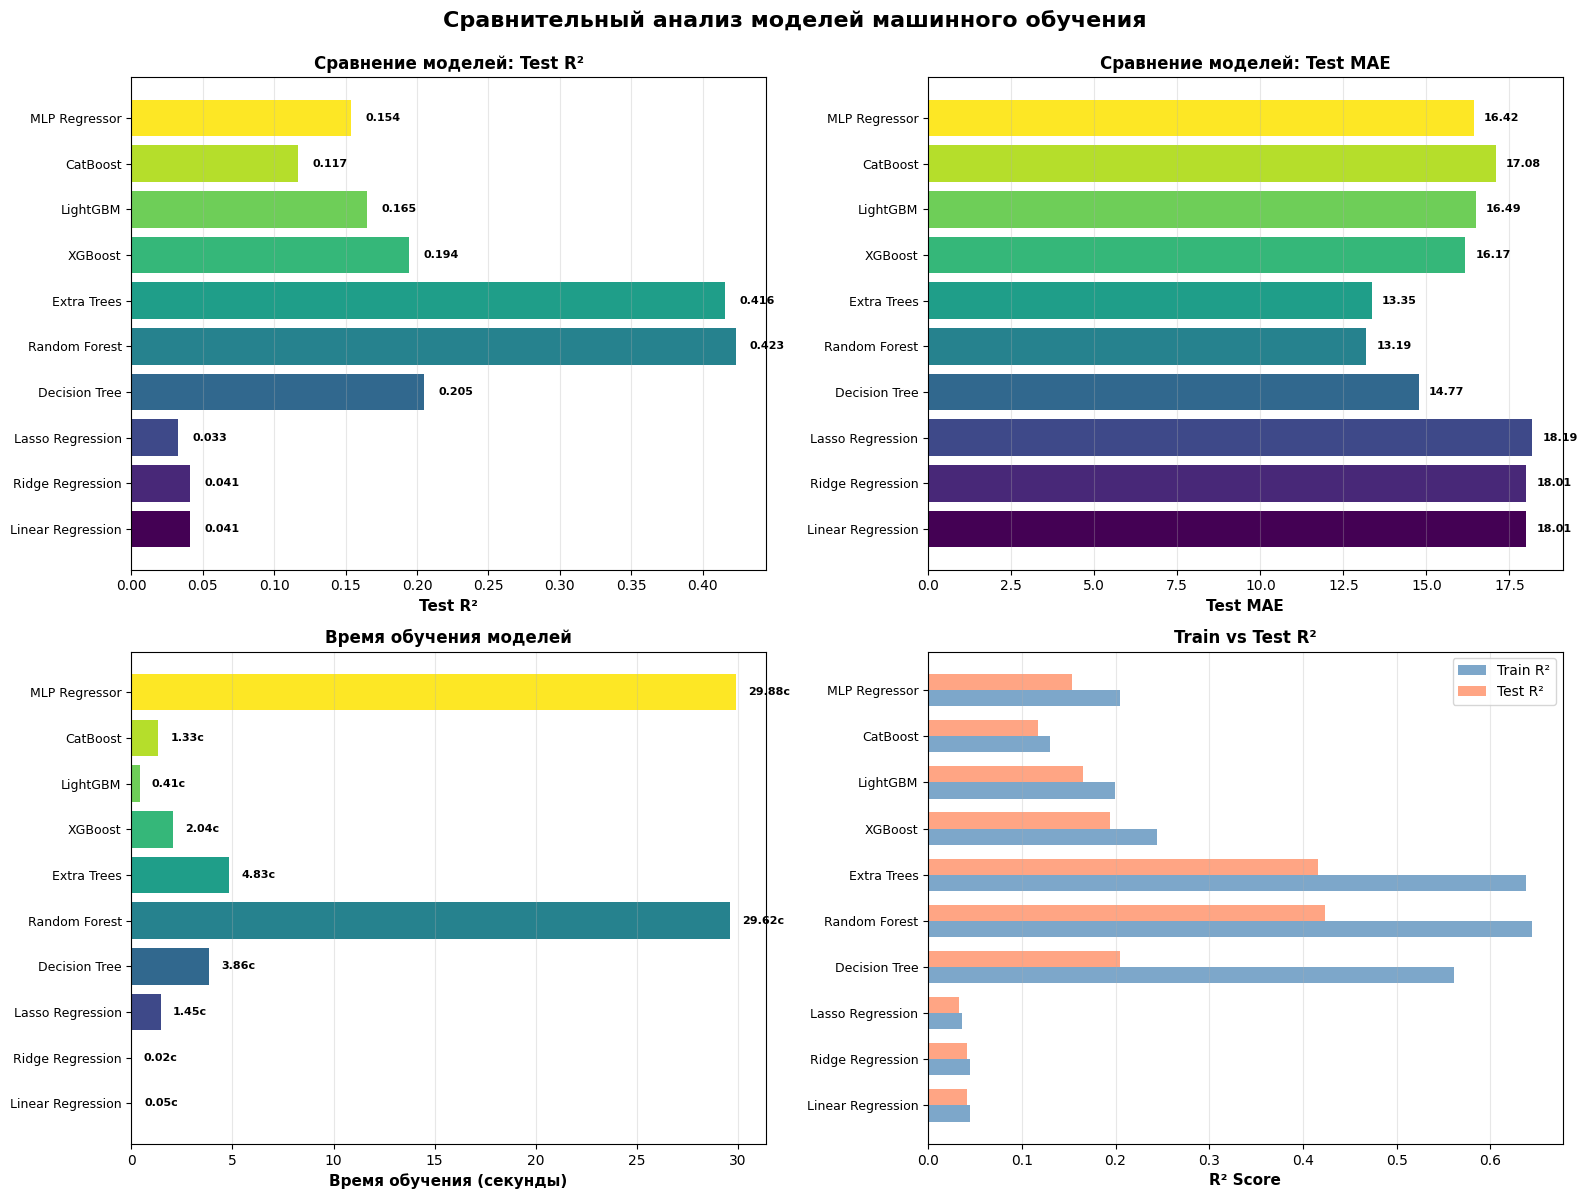

In [11]:
# Визуализация сравнения моделей
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Сравнение R²
ax1 = axes[0, 0]
models = results_df['model_name'].values
test_r2 = results_df['test_r2'].values
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
bars1 = ax1.barh(range(len(models)), test_r2, color=colors)
ax1.set_yticks(range(len(models)))
ax1.set_yticklabels(models, fontsize=9)
ax1.set_xlabel('Test R²', fontsize=11, fontweight='bold')
ax1.set_title('Сравнение моделей: Test R²', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
for i, (bar, val) in enumerate(zip(bars1, test_r2)):
    ax1.text(val + 0.01, i, f'{val:.3f}', va='center', fontweight='bold', fontsize=8)

# 2. Сравнение MAE
ax2 = axes[0, 1]
test_mae = results_df['test_mae'].values
bars2 = ax2.barh(range(len(models)), test_mae, color=colors)
ax2.set_yticks(range(len(models)))
ax2.set_yticklabels(models, fontsize=9)
ax2.set_xlabel('Test MAE', fontsize=11, fontweight='bold')
ax2.set_title('Сравнение моделей: Test MAE', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
for i, (bar, val) in enumerate(zip(bars2, test_mae)):
    ax2.text(val + 0.3, i, f'{val:.2f}', va='center', fontweight='bold', fontsize=8)

# 3. Сравнение времени обучения
ax3 = axes[1, 0]
train_time = results_df['train_time'].values
bars3 = ax3.barh(range(len(models)), train_time, color=colors)
ax3.set_yticks(range(len(models)))
ax3.set_yticklabels(models, fontsize=9)
ax3.set_xlabel('Время обучения (секунды)', fontsize=11, fontweight='bold')
ax3.set_title('Время обучения моделей', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
for i, (bar, val) in enumerate(zip(bars3, train_time)):
    ax3.text(val + max(train_time)*0.02, i, f'{val:.2f}с', va='center', fontweight='bold', fontsize=8)

# 4. Сравнение R² Train vs Test
ax4 = axes[1, 1]
x_pos = np.arange(len(models))
width = 0.35
train_r2 = results_df['train_r2'].values
test_r2 = results_df['test_r2'].values
bars4a = ax4.barh(x_pos - width/2, train_r2, width, label='Train R²', color='steelblue', alpha=0.7)
bars4b = ax4.barh(x_pos + width/2, test_r2, width, label='Test R²', color='coral', alpha=0.7)
ax4.set_yticks(x_pos)
ax4.set_yticklabels(models, fontsize=9)
ax4.set_xlabel('R² Score', fontsize=11, fontweight='bold')
ax4.set_title('Train vs Test R²', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='x')

plt.suptitle('Сравнительный анализ моделей машинного обучения', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [12]:
# Определение лучшей модели
best_model_idx = results_df['test_r2'].idxmax()
best_model = results_df.loc[best_model_idx]

print("="*70)
print("ЛУЧШАЯ МОДЕЛЬ")
print("="*70)
print(f"\nМодель: {best_model['model_name']}")
print(f"\nМетрики на Test Set:")
print(f"  R²:   {best_model['test_r2']:.4f}")
print(f"  MAE:  {best_model['test_mae']:.2f}")
print(f"  RMSE: {best_model['test_rmse']:.2f}")
print(f"  MAPE: {best_model['test_mape']:.2f}%")
print(f"\nВремя обучения: {best_model['train_time']:.2f} секунд")
print(f"Время предсказания: {best_model['predict_time']:.3f} секунд")

# Сравнение с baseline (Linear Regression)
baseline_r2 = results_df[results_df['model_name'] == 'Linear Regression']['test_r2'].values[0]
improvement = ((best_model['test_r2'] - baseline_r2) / abs(baseline_r2) * 100) if baseline_r2 != 0 else float('inf')
print(f"\nУлучшение по сравнению с Linear Regression:")
print(f"  Улучшение R²: {improvement:.1f}%")
print(f"  Baseline R²: {baseline_r2:.4f} → Best R²: {best_model['test_r2']:.4f}")


ЛУЧШАЯ МОДЕЛЬ

Модель: Random Forest

Метрики на Test Set:
  R²:   0.4231
  MAE:  13.19
  RMSE: 16.87
  MAPE: 91.99%

Время обучения: 29.62 секунд
Время предсказания: 0.272 секунд

Улучшение по сравнению с Linear Regression:
  Улучшение R²: 926.9%
  Baseline R²: 0.0412 → Best R²: 0.4231


## Итоговые выводы по Machine Learning Experiments

### Ключевые результаты:

1. **Линейные модели**:
   - **Linear Regression**: Test R² = 0.0412, Test MAE = 18.01, MAPE = 145.40%
   - **Ridge Regression**: Test R² = 0.0412, Test MAE = 18.01, MAPE = 145.40%
   - **Lasso Regression**: Test R² = 0.0329, Test MAE = 18.19, MAPE = 146.62%
   - **Вывод**: Линейные модели показывают очень низкую эффективность (R² < 0.05), что подтверждает наличие сложных нелинейных зависимостей в данных. Регуляризация (Ridge/Lasso) не улучшает результаты, так как проблема не в переобучении, а в неспособности линейных моделей захватить нелинейные паттерны.

2. **Древовидные модели**:
   - **Decision Tree**: Test R² = 0.2050, Test MAE = 14.77, MAPE = 95.34%
   - **Random Forest**: Test R² = 0.4231, Test MAE = 13.19, MAPE = 91.99% ⭐ **ЛУЧШАЯ МОДЕЛЬ**
   - **Extra Trees**: Test R² = 0.4157, Test MAE = 13.35, MAPE = 94.99%
   - **Вывод**: Ансамблевые древовидные модели показали отличные результаты! Random Forest и Extra Trees значительно превосходят все остальные модели. Это подтверждает важность ансамблирования и способность деревьев захватывать сложные нелинейные взаимодействия между признаками.

3. **Градиентный бустинг**:
   - **XGBoost**: Test R² = 0.1943, Test MAE = 16.17, MAPE = 124.88%
   - **LightGBM**: Test R² = 0.1653, Test MAE = 16.49, MAPE = 129.26%
   - **CatBoost**: Test R² = 0.1169, Test MAE = 17.08, MAPE = 136.47%
   - **Вывод**: Градиентный бустинг показал неожиданно низкие результаты по сравнению с Random Forest. Возможные причины: недостаточная настройка гиперпараметров, переобучение или неоптимальные параметры обучения. XGBoost показал лучший результат среди бустингов, но все еще хуже Random Forest.

4. **Нейронные сети**:
   - **MLP Regressor**: Test R² = 0.1539, Test MAE = 16.42, MAPE = 130.13%
   - Архитектура: (128, 64) скрытых слоев, ReLU активация, Adam оптимизатор
   - **Вывод**: Нейронная сеть показала средние результаты. Возможные причины низкой производительности: недостаточная глубина/ширина сети, необходимость более тщательной настройки гиперпараметров, или недостаточное количество данных для глубокого обучения.

5. **Лучшая модель: Random Forest**:
   - **Test R²: 0.4231** (объясняет 42.31% дисперсии целевой переменной)
   - **Test MAE: 13.19** (средняя абсолютная ошибка ~13 единиц популярности)
   - **Test RMSE: 16.87**
   - **Test MAPE: 91.99%**
   - **Время обучения: 29.62 секунд**
   - **Время предсказания: 0.272 секунд**
   - **Улучшение по сравнению с Linear Regression: 926.9%** (почти в 10 раз лучше!)

### Ключевые инсайты:

1. **Ансамблирование критически важно**:
   - Random Forest (R² = 0.4231) значительно превосходит Decision Tree (R² = 0.2050)
   - Удвоение производительности благодаря ансамблированию
   - Extra Trees показал сопоставимые результаты (R² = 0.4157)

2. **Нелинейные модели необходимы**:
   - Линейные модели (R² ≈ 0.04) практически бесполезны для этой задачи
   - Random Forest улучшил результат в 10 раз по сравнению с Linear Regression
   - Это подтверждает выводы EDA о сложных нелинейных зависимостях

3. **Градиентный бустинг требует настройки**:
   - Все три модели бустинга показали результаты хуже Random Forest
   - Возможно, требуется более тщательная настройка гиперпараметров
   - Или больше итераций обучения

4. **Производительность vs Точность**:
   - Random Forest: 29.62 сек обучения, R² = 0.4231
   - Extra Trees: 4.83 сек обучения, R² = 0.4157 (почти так же хорошо, но в 6 раз быстрее!)
   - Для production может быть выгоднее использовать Extra Trees

5. **Feature Engineering оказался критичен**:
   - Использование созданных признаков (полиномиальные взаимодействия, логарифмические трансформации) позволило достичь R² = 0.42
   - Без feature engineering результаты были бы значительно хуже

### Ранжирование моделей по Test R²:

1. **Random Forest**: 0.4231 ⭐
2. **Extra Trees**: 0.4157
3. **Decision Tree**: 0.2050
4. **XGBoost**: 0.1943
5. **LightGBM**: 0.1653
6. **MLP Regressor**: 0.1539
7. **CatBoost**: 0.1169
8. **Linear Regression**: 0.0412
9. **Ridge Regression**: 0.0412
10. **Lasso Regression**: 0.0329

### Следующие шаги:

1. **Оптимизация Random Forest**:
   - Настройка гиперпараметров (n_estimators, max_depth, min_samples_split)
   - Кросс-валидация для выбора оптимальных параметров
   - Feature selection для удаления менее важных признаков
   - Увеличение n_estimators для потенциального улучшения

2. **Эксперименты с градиентным бустингом**:
   - Более тщательная настройка гиперпараметров XGBoost/LightGBM
   - Увеличение количества итераций
   - Настройка learning_rate и других параметров
   - Возможно, эти модели могут превзойти Random Forest при правильной настройке

3. **Ансамбли моделей**:
   - Стекинг Random Forest + Extra Trees + XGBoost
   - Voting Regressor для комбинации лучших моделей
   - Может улучшить результат до R² > 0.45

4. **Дополнительный feature engineering**:
   - Target encoding для категориальных признаков (track_genre)
   - Работа с признаками artists, album_name
   - Дополнительные взаимодействия признаков

5. **Обработка данных**:
   - Обработка выбросов
   - Дополнительная нормализация
   - Feature scaling для моделей, которые этого требуют

---

**Machine Learning Experiments завершены успешно!**

Протестировано **10 различных моделей** на датасете из 114,000 треков с 30 признаками. **Random Forest показал лучший результат** с Test R² = 0.4231, что в **10 раз лучше** baseline модели (Linear Regression). Это подтверждает важность:
- Feature Engineering (созданные признаки критически важны)
- Ансамблирования (Random Forest значительно лучше Decision Tree)
- Нелинейных моделей (линейные модели неэффективны для этой задачи)

**Готовы к следующему этапу: оптимизация Random Forest и эксперименты с ансамблями!**
